In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
tf.logging.set_verbosity(tf.logging.ERROR)
tf.reset_default_graph()

import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display

In [2]:
data = input_data.read_data_sets("data/mnist",one_hot=True)

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


In [3]:
#Generator

def generator(z, c,reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        
        #initialize weights
        w_init = tf.contrib.layers.xavier_initializer()
        
        #concatenate noize z and conditional  variable c to form an input
        inputs = tf.concat([z, c], 1)
        
        #define the first layer with relu activation
        dense1 = tf.layers.dense(inputs, 128, kernel_initializer=w_init)
        relu1 = tf.nn.relu(dense1)
        
        #define the second layer and compute the output using the tanh activation function
        logits = tf.layers.dense(relu1, 784, kernel_initializer=w_init)
        output = tf.nn.tanh(logits)

        return output

In [4]:
#Discriminator

def discriminator(x, c, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        
        #initialize weights
        w_init = tf.contrib.layers.xavier_initializer()
        
        #concatenate noize z and conditional variable c to form an input
        inputs = tf.concat([x, c], 1)
    
        #define the first layer with the relu activation
        dense1 = tf.layers.dense(inputs, 128, kernel_initializer=w_init)
        relu1 = tf.nn.relu(dense1)
        
        #define the second layer and compute the output using sigmoid activation function
        logits = tf.layers.dense(relu1, 1, kernel_initializer=w_init)
        output = tf.nn.sigmoid(logits)

        return logits

In [5]:
x = tf.placeholder(tf.float32, shape=(None, 784))
c = tf.placeholder(tf.float32, shape=(None, 10))
z = tf.placeholder(tf.float32, shape=(None, 100))

In [6]:
fake_x = generator(z, c)

In [7]:
D_logits_real = discriminator(x,c) 

In [8]:
D_logits_fake = discriminator(fake_x, c, reuse=True)

In [9]:
#Discriminator loss
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_real,
                                                                     labels=tf.ones_like(D_logits_real)))

In [10]:
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_fake,
                                                                     labels=tf.zeros_like(D_logits_fake)))

In [11]:
D_loss = D_loss_real + D_loss_fake

In [12]:
#Generator loss
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_fake,
                                                                labels=tf.ones_like(D_logits_fake)))

In [13]:
training_vars = tf.trainable_variables()
theta_D = [var for var in training_vars if var.name.startswith('discriminator')]
theta_G = [var for var in training_vars if var.name.startswith('generator')]

In [14]:
D_optimizer = tf.train.AdamOptimizer(0.001, beta1=0.5).minimize(D_loss, var_list=theta_D)
G_optimizer = tf.train.AdamOptimizer(0.001, beta1=0.5).minimize(G_loss, var_list=theta_G)

In [15]:
session = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [23]:
batch_size = 128
num_epochs = 10
num_classes = 10

In [24]:
images = data.train.images
labels = data.train.labels

In [25]:
images.shape

(55000, 784)

In [26]:
label_to_generate = 7
onehot = np.eye(10)

In [27]:
onehot

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

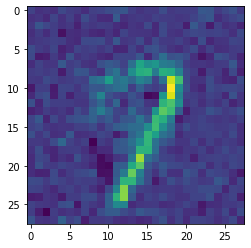

In [30]:
for epoch in range(num_epochs):

    for i in range(len(images) // batch_size):
        
        #sample images
        batch_image = images[i * batch_size:(i + 1) * batch_size]
        
        #sample the condition that is, digit we want to generate
        batch_c = labels[i * batch_size:(i + 1) * batch_size]
        
        #sample noise
        batch_noise = np.random.normal(0, 1, (batch_size, 100))
        
        #train the generator
        generator_loss, _ = session.run([D_loss, D_optimizer], {x: batch_image, c: batch_c, z: batch_noise})
           
        #train the discriminator
        discriminator_loss, _ = session.run([G_loss, G_optimizer],  {x: batch_image, c: batch_c, z: batch_noise})
    
    #sample noise
    noise = np.random.rand(1,100)
    
    #select specific digit
    gen_label = np.array([[label_to_generate]]).reshape(-1)
    
    #convert the selected digit
    one_hot_targets = np.eye(num_classes)[gen_label]
    
    print("es",one_hot_targets)
    
    #Feed the noise and one hot encoded condition to the generator and generate the fake image
    _fake_x = session.run(fake_x, {z: noise, c: one_hot_targets})
    _fake_x = _fake_x.reshape(28,28)
    
   
    
    print("Epoch: {},Discriminator Loss:{}, Generator Loss: {}".format(epoch,discriminator_loss,generator_loss))
    
    #plot the generated image
    display.clear_output(wait=True)
    plt.imshow(_fake_x) 
    plt.show()